In [118]:
import numpy as np
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import plotly.express as px
from collections import Counter
from textblob import TextBlob
from wordcloud import WordCloud

In [119]:
dataset=pd.read_csv('vaccination_tweets.csv')
dataset.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [120]:
dataset.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [121]:
dataset.dtypes

id                   int64
user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
retweets             int64
favorites            int64
is_retweet            bool
dtype: object

In [122]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2207 entries, 0 to 2206
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                2207 non-null   int64 
 1   user_name         2207 non-null   object
 2   user_location     1734 non-null   object
 3   user_description  2099 non-null   object
 4   user_created      2207 non-null   object
 5   user_followers    2207 non-null   int64 
 6   user_friends      2207 non-null   int64 
 7   user_favourites   2207 non-null   int64 
 8   user_verified     2207 non-null   bool  
 9   date              2207 non-null   object
 10  text              2207 non-null   object
 11  hashtags          1649 non-null   object
 12  source            2206 non-null   object
 13  retweets          2207 non-null   int64 
 14  favorites         2207 non-null   int64 
 15  is_retweet        2207 non-null   bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 245.8+ KB


In [123]:
dataset.describe()

,id,user_followers,user_friends,user_favourites,retweets,favorites
count,2.207000e+03,2.207000e+03,2207.000000,2207.000000,2207.000000,2207.000000
mean,1.341306e+18,6.724004e+04,1163.639329,13309.777526,1.792025,10.825555
std,2.320079e+15,5.031354e+05,2455.800997,42391.551808,13.030328,79.428203
min,1.337728e+18,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.339305e+18,1.125000e+02,165.000000,335.000000,0.000000,0.000000
50%,1.341122e+18,6.260000e+02,442.000000,1578.000000,0.000000,1.000000
75%,1.343287e+18,3.142000e+03,1191.000000,9312.500000,1.000000,4.000000
max,1.345812e+18,1.371493e+07,64432.000000,924667.000000,446.000000,2129.000000


In [124]:
dataset.isnull().sum()

id                    0
user_name             0
user_location       473
user_description    108
user_created          0
user_followers        0
user_friends          0
user_favourites       0
user_verified         0
date                  0
text                  0
hashtags            558
source                1
retweets              0
favorites             0
is_retweet            0
dtype: int64

In [125]:
dataset['user_verified'].value_counts()

False    1888
True      319
Name: user_verified, dtype: int64

# Data Manipulation

In [126]:
#verified account or not
dataset['user_verified']=dataset['user_verified'].apply(lambda x:'verified' if x==True else 'not_verified')

In [127]:
#account age
from datetime import date
dataset['today']=date.today()
dataset['user_created']=pd.to_datetime(dataset['user_created']).dt.year
dataset['today']=pd.to_datetime(dataset['today'])
dataset['today']=dataset['today'].dt.year
dataset['acc_age']= dataset['today']-dataset['user_created']

In [128]:
#converting date to date format
dataset['date']=pd.to_datetime(dataset['date'])

In [129]:
L = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']
dataset = dataset.join(pd.concat((getattr(dataset['date'].dt, i).rename(i) for i in L), axis=1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [130]:
#total enagement
dataset['total_engagement']=dataset['retweets']+dataset['favorites']

In [131]:
dataset['tweet_lenght']=dataset['text'].apply(lambda x:len(x))
dataset['tweet_lenght'].describe()

count    2207.000000
mean      131.251473
std        17.334732
min        35.000000
25%       131.000000
50%       139.000000
75%       140.000000
max       148.000000
Name: tweet_lenght, dtype: float64

In [132]:
#The tweet length can be no longer than 280 characters so let's check tweets length
dataset['tweet_lenght']=dataset['text'].apply(lambda x:len(x))
dataset['tweet_lenght'].describe()

count    2207.000000
mean      131.251473
std        17.334732
min        35.000000
25%       131.000000
50%       139.000000
75%       140.000000
max       148.000000
Name: tweet_lenght, dtype: float64

In [133]:
#tweet length cases
dataset['tweet_length']=dataset['text'].apply(lambda x:'short' if len(x)<=130 else 'long')

In [134]:
#fix country location
loc_dataset = dataset['user_location'].str.split(',',expand=True)
loc_dataset=loc_dataset.rename(columns={0:'fst_loc',1:'snd_loc'})

In [135]:
#fixing states with country shortcut
# Remove Spaces 
loc_dataset['snd_loc'] = loc_dataset['snd_loc'].str.strip()
# Rename States 
state_fix = {'Ontario': 'Canada','United Arab Emirates': 'UAE','TX': 'USA','NY': 'USA'
                  ,'FL': 'USA','England': 'UK','Watford': 'UK','GA': 'USA','IL': 'USA'
                  ,'Alberta': 'Canada','WA': 'USA','NC': 'USA','British Columbia': 'Canada','MA': 'USA','ON':'Canada'
            ,'OH':'USA','MO':'USA','AZ':'USA','NJ':'USA','CA':'USA','DC':'USA','AB':'USA','PA':'USA','SC':'USA'
            ,'VA':'USA','TN':'USA','New York':'USA','Dubai':'UAE','CO':'USA'}
loc_dataset = loc_dataset.replace({"snd_loc": state_fix}) 
loc_dataset['snd_loc'].value_counts()[:10]

USA               267
UK                118
India              78
Canada             57
UAE                34
United Kingdom     19
Ireland            13
France              8
Germany             8
Nederland           7
Name: snd_loc, dtype: int64

In [166]:
#engament
line = dataset.groupby('date',as_index=False).agg({'total_engagement':'sum'})
fig = go.Figure()
fig.add_trace(go.Scatter(x=line.date, y=line.total_engagement,
                    mode='lines+markers'))

In [136]:
dataset['user_location'] = dataset['user_location'].fillna('NaN')
dataset['source'] = dataset['source'].fillna('NaN')
dataset['hashtags'] = dataset['hashtags'].fillna('NaN')

locations = pd.Series(Counter(dataset['user_location'])).sort_values(ascending=False)
locations = locations.drop('NaN')[locations>5]

source = Counter(dataset['source'])
source = pd.Series(source).sort_values(ascending=False)

verified = Counter(dataset['user_verified'])
verified = pd.Series(verified).sort_values(ascending=False)

name = Counter(dataset['user_name'])
name = pd.Series(name).sort_values(ascending=False)
name = name[name>4]

hashtags = []
for i in dataset['hashtags']:
    for j in i.translate(str.maketrans('', '', string.punctuation)).split(' '):
        hashtags.append(j)
hashtags = Counter(hashtags)
hashtags = pd.Series(hashtags).sort_values(ascending=False)
hashtags = hashtags[hashtags>8]

followers = dataset.sort_values(by='user_followers', ascending=False)
followers_i = followers['user_name'].drop_duplicates().keys()[:15]

friends = dataset.sort_values(by='user_friends', ascending=False)[:15]
friends_i = friends['user_name'].drop_duplicates().keys()

favourites = dataset.sort_values(by='user_favourites', ascending=False)
favourites_i = favourites['user_name'].drop_duplicates().keys()[:15]


# Visualisation of Data

## Bar Plot

In [137]:
def barplot(x, y, title, xlabel, ylabel, capsize=12, fontsize=12, labelsize=9, 
            palette='twilight', rotation=0, figsize=(13, 13), bartext_size=15):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    bars = sns.barplot(x, y, palette=palette, capsize=capsize)
    for bar in bars.patches:
        bars.annotate(format(bar.get_height(), '.0f'), 
                  (bar.get_x()+bar.get_width()/2., bar.get_height()), ha='center', va='bottom',
                    size=bartext_size)
    
    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks(rotation=rotation)
    plt.tick_params(axis='x', labelsize=labelsize)
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



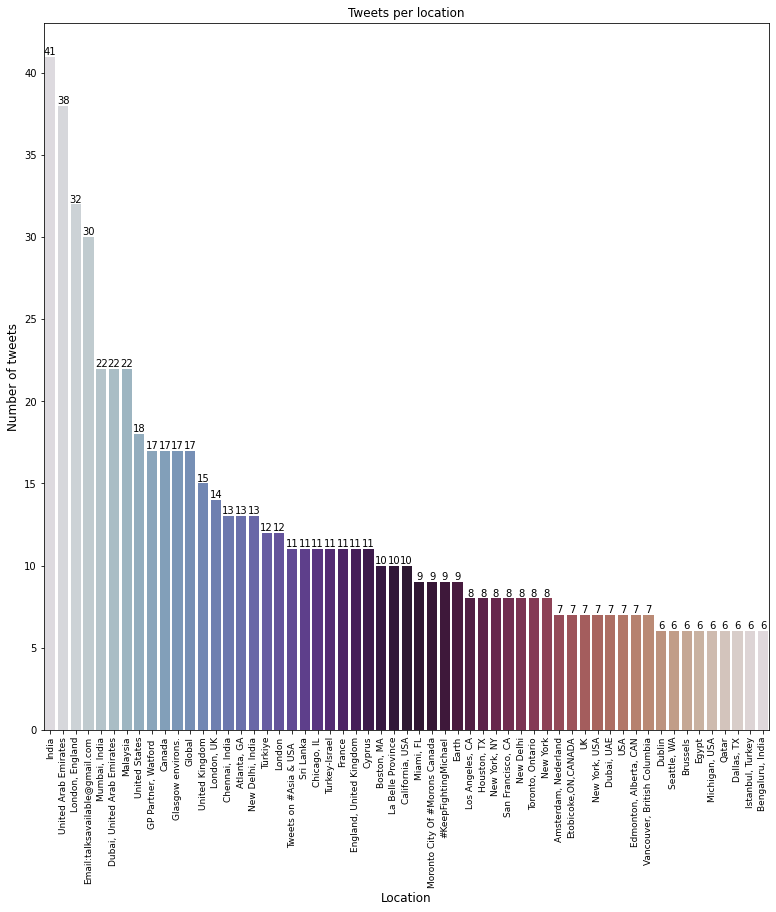

In [138]:
barplot(locations.keys(), locations, title='Tweets per location', xlabel='Location', 
        ylabel='Number of tweets', rotation=90, bartext_size=10)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



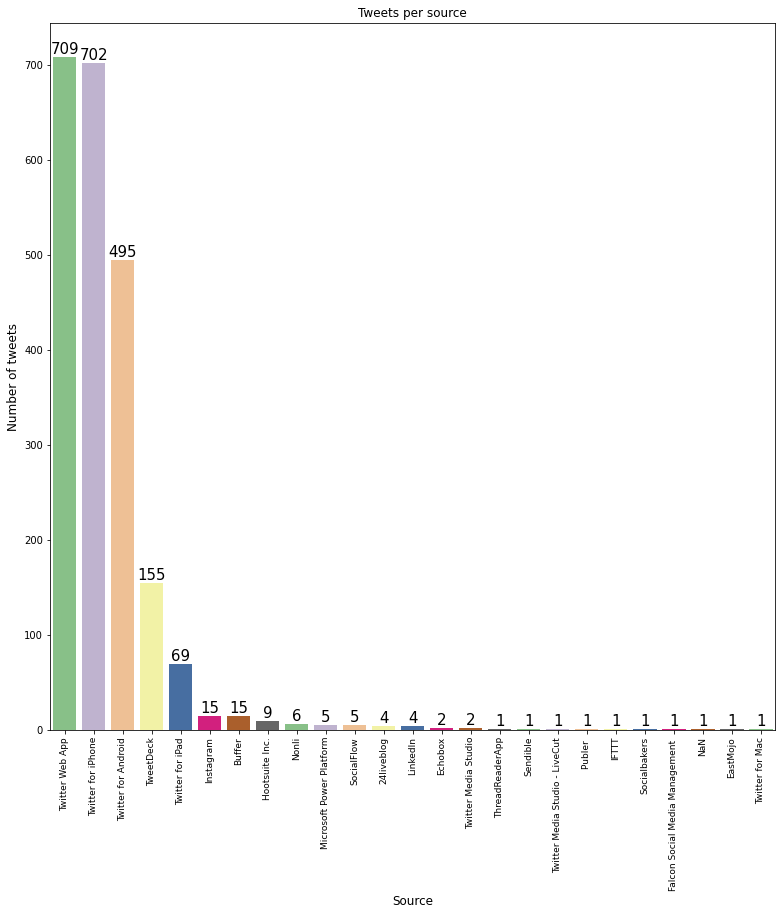

In [139]:
barplot(source.keys(), source, title='Tweets per source', xlabel='Source', 
        ylabel='Number of tweets', palette='Accent', rotation=90)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 129505 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128155 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128154 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128153 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128156 missing from current font.

/usr/loc

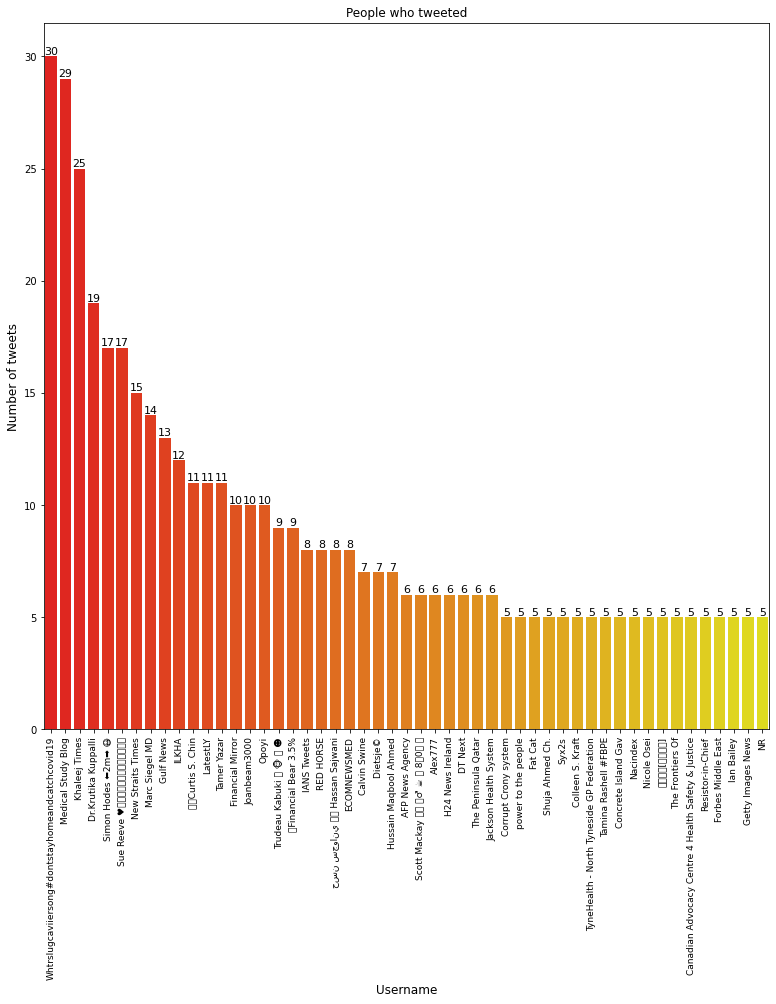

In [140]:
barplot(name.keys(), name, 'People who tweeted', 'Username', 'Number of tweets', rotation=90,
       palette='autumn', bartext_size=11)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



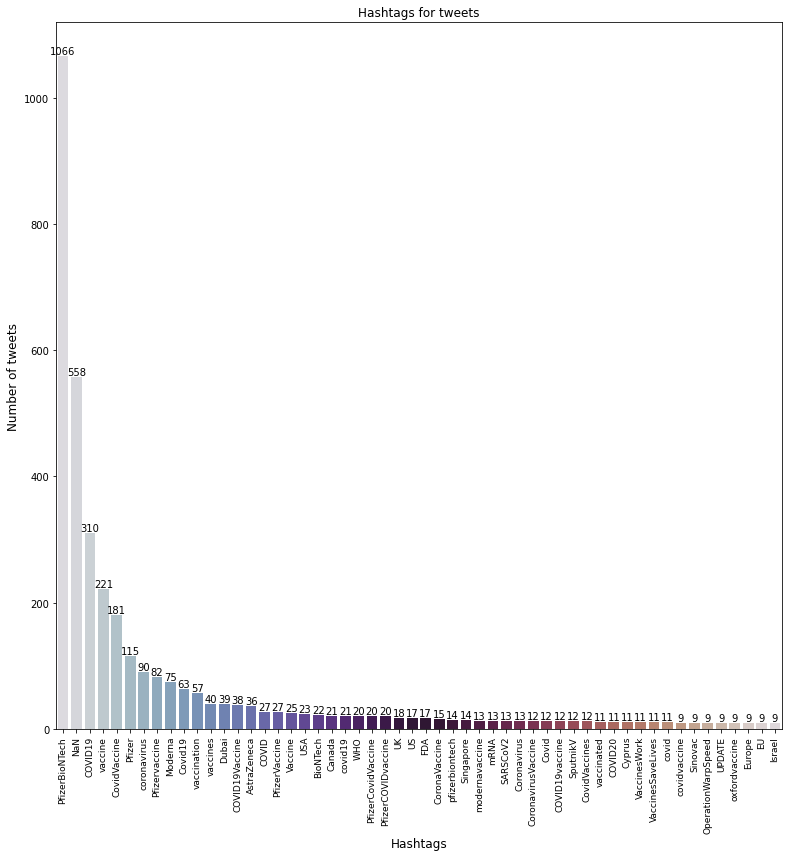

In [141]:
barplot(hashtags.keys(), hashtags, 'Hashtags for tweets', 'Hashtags', 'Number of tweets',
       rotation=90, bartext_size=10)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



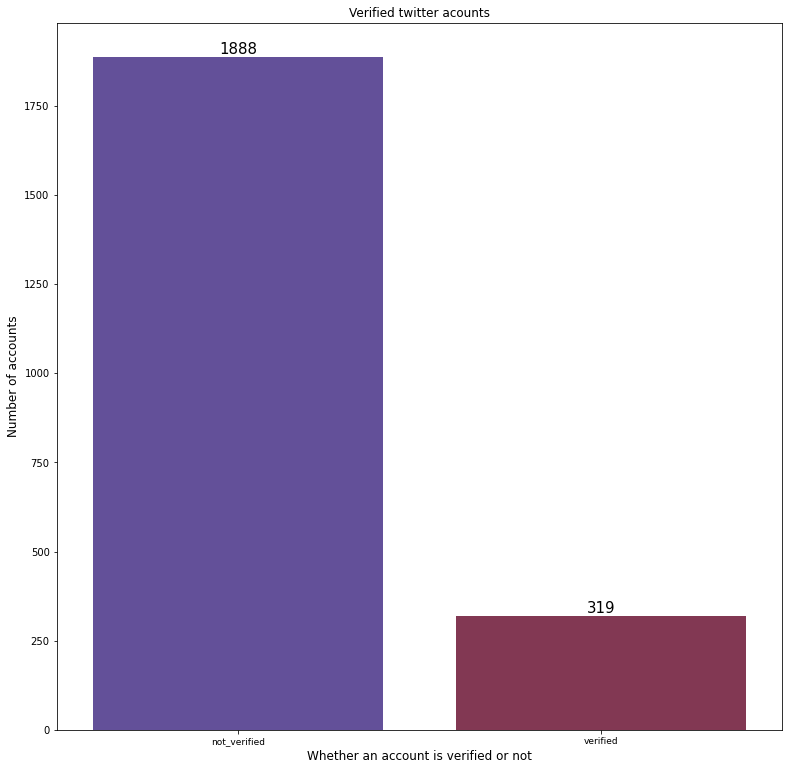

In [142]:
barplot(verified.keys(), verified, 'Verified twitter acounts', 
        'Whether an account is verified or not', 'Number of accounts')

## Pie Plots

In [143]:
def piechart(x, y, title, figsize=(10, 13)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    plt.pie(x, labels=y, autopct=lambda p:f'{p:.2f}%')
    plt.title(title)
    plt.show()

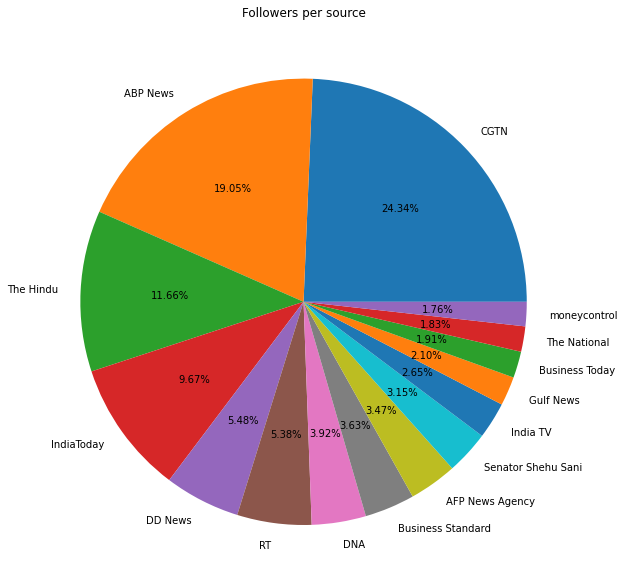

In [144]:
piechart(followers['user_followers'][followers_i], followers['user_name'][followers_i],'Followers per source')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127464 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127462 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127468 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127463 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127479 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127487 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127482 missing from current font.

/usr/local/lib/python3.6/dist-packages/ma

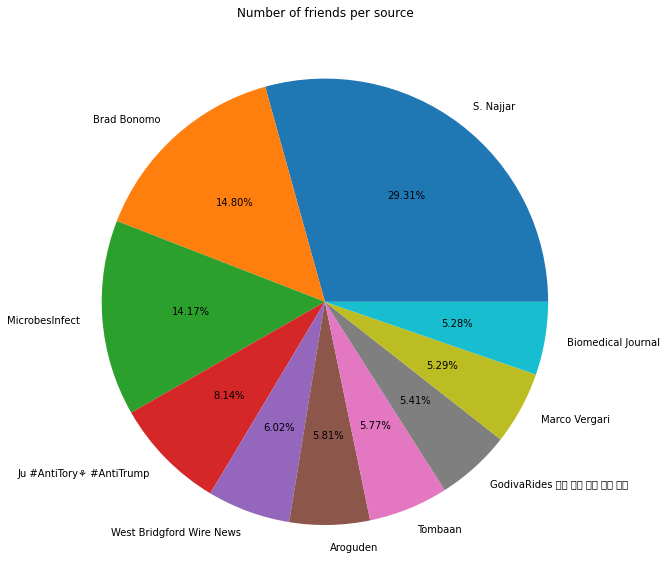

In [145]:
piechart(friends['user_friends'][friends_i], friends['user_name'][friends_i],'Number of friends per source')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127754 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128406 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128129 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127759 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127876 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127809 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127793 missing from current font.

/usr/local/lib/python3.6/dist-packages/ma

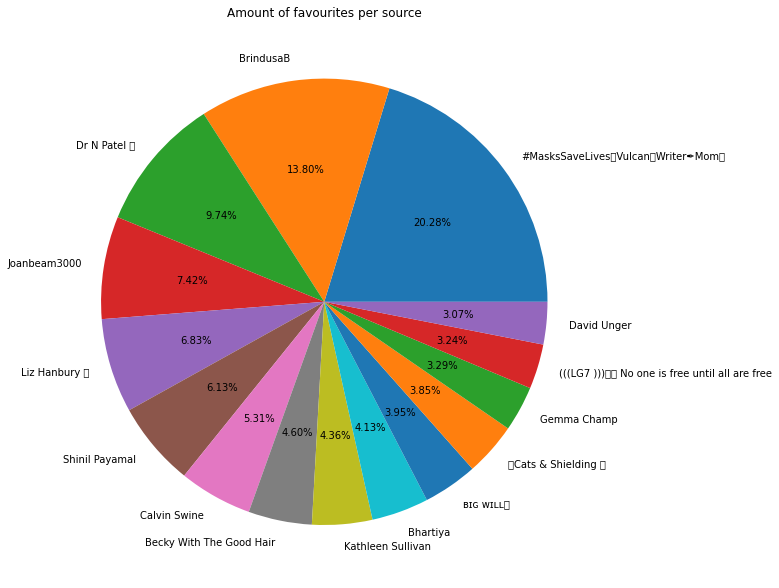

In [165]:
piechart(favourites['user_favourites'][favourites_i], favourites['user_name'][favourites_i],'Amount of favourites per source')

## Line Graphs

In [147]:
def time_plot(time, title, x, y):
    count = Counter(time)
    count = pd.Series(dict(zip(count.values(), [int(i) for i in count.keys()]))).sort_values()

    fig, ax = plt.subplots(1, 1, figsize=(13, 10))
    ax.plot([str(i) for i in count], count.keys())
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    plt.show()

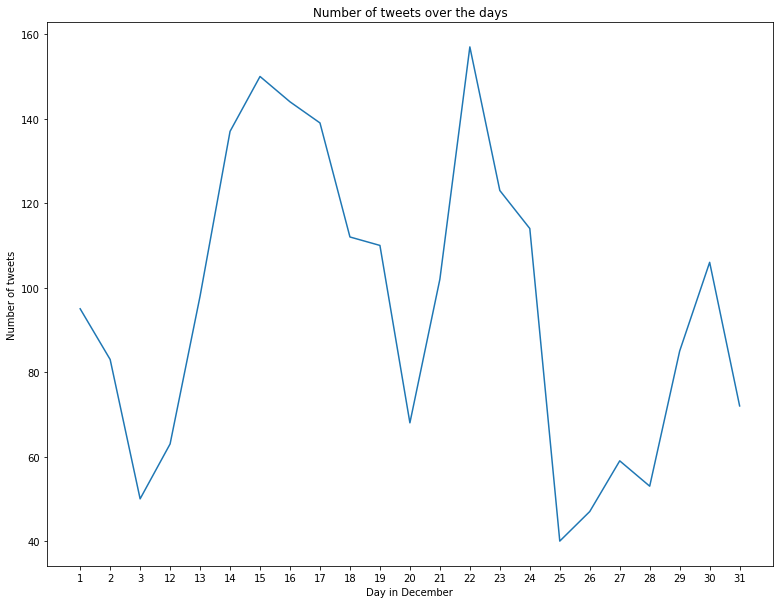

In [148]:
time_plot([str(i)[8:10] for i in dataset['date']], 'Number of tweets over the days','Day in December', 'Number of tweets')

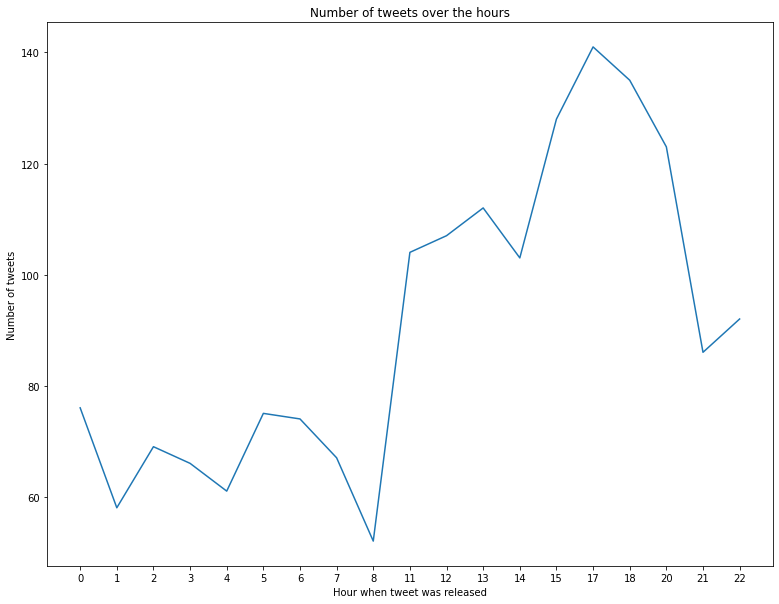

In [149]:
time_plot([str(i)[11:13] for i in dataset['date']], 'Number of tweets over the hours','Hour when tweet was released', 'Number of tweets')

## Heatmap

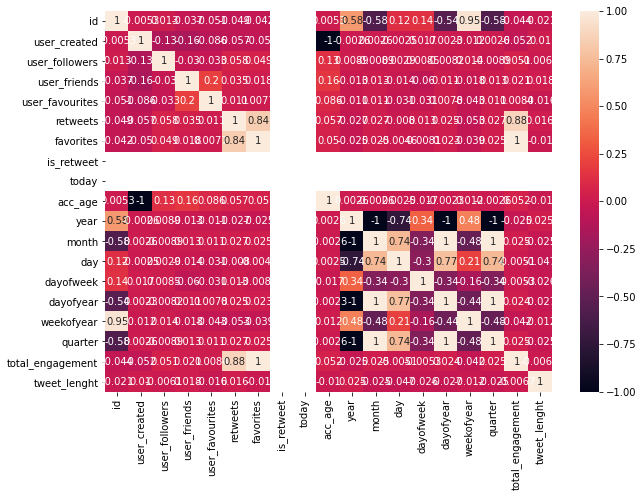

In [150]:
corr=dataset.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr,annot=True)

## Countplot

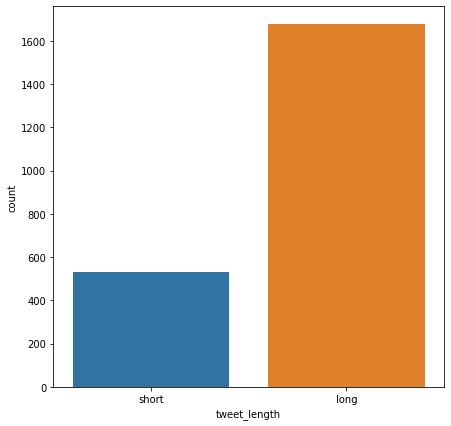

In [151]:
dataset['tweet_length']=dataset['text'].apply(lambda x:'short' if len(x)<=130 else 'long')
plt.figure(figsize=(7,7))
sns.countplot(x='tweet_length',data=dataset);

In [152]:
df3=pd.DataFrame(loc_dataset['snd_loc'].value_counts()[:20]).reset_index()
df3

,index,snd_loc
0,USA,267
1,UK,118
2,India,78
3,Canada,57
4,UAE,34
5,United Kingdom,19
6,Ireland,13
7,France,8
8,Germany,8
9,Nederland,7


In [153]:
fig = px.choropleth(df3, locations = df3['index'],
                    color = df3['snd_loc'],locationmode='country names',hover_name = df3['snd_loc'], 
                    color_continuous_scale = px.colors.sequential.Inferno)
fig.update_layout(title='Sales tracking')
fig.show()

# Sentiment Analysis

In [154]:
tweets = dataset['text']

In [155]:
all_sentences = []

for word in tweets:
    all_sentences.append(word)

all_sentences

lines = list()
for line in all_sentences:    
    words = line.split()
    for w in words: 
       lines.append(w)

In [156]:
import re

lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]

lines

lines2 = []

for word in lines:
    if word != '':
        lines2.append(word)

In [157]:
features=tweets.values
features

array(['Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF',
       "While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",
       '#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P',
       ...,
       'BILL GATES &amp; WALTER WHITE ON - BREAKING GATES - Painting by Alejandro Be... https://t.co/SgDDtNj38Z via @YouTube… https://t.co/N0WRgOMLkr',
       'Words can’t express how grateful I am to all those who made the COVID vaccines possible and looking forward to the… https://t.co/Bs1sRg0qFd',
       '@DailyMailUK While I trust the #Pfizervaccine I would never trust the Oxford. Have you seen the kind of moronic twa… https://t.co/N7xgFdA1c8'],
      dtype=object)

In [158]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the Http: urls
    processed_feature = re.sub('(https?://\S+)', '', str(features[sentence]))
    
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', processed_feature)

    # Remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [159]:
features[:5]

array(['Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF',
       "While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",
       '#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P',
       "Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",
       'Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq'],
      dtype=object)

In [160]:
processed_features[:5]

['same folks said daikon paste could treat cytokine storm pfizerbiontech ',
 'while the world has been on the wrong side of history this year hopefully the biggest vaccination effort we ve ev ',
 ' coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_19 russian vaccine is created to last 2 4 years ',
 'facts are immutable senator even when you re not ethically sturdy enough to acknowledge them 1 you were born ',
 'explain to me again why we need vaccine borisjohnson matthancock whereareallthesickpeople pfizerbiontech ']

Adding Subjectivity and Polarity

In [161]:
ds=pd.DataFrame()
ds['Tweets']=processed_features

In [162]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
ds['Subjectivity'] = ds['Tweets'].apply(getSubjectivity)
ds['Polarity'] = ds['Tweets'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
ds

,Tweets,Subjectivity,Polarity
0,same folks said daikon paste could treat cytok...,0.125000,0.00
1,while the world has been on the wrong side of ...,0.900000,-0.50
2,coronavirus sputnikv astrazeneca pfizerbionte...,0.033333,0.00
3,facts are immutable senator even when you re n...,0.550000,-0.05
4,explain to me again why we need vaccine borisj...,0.000000,0.00
...,...,...,...
2202,got my covid19 vaccine early morning on decemb...,0.300000,0.10
2203,where is tiffanydover why no one has news from...,0.000000,0.00
2204,bill gates amp walter white on breaking gates ...,0.000000,0.00
2205,words can express how grateful am to all those...,1.000000,0.00


Creating Sentiment Analysis

In [163]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
 if score < 0:
  return 'Negative'
 elif score == 0:
  return 'Neutral'
 else:
  return 'Positive'
ds['Analysis'] = ds['Polarity'].apply(getAnalysis)
ds

,Tweets,Subjectivity,Polarity,Analysis
0,same folks said daikon paste could treat cytok...,0.125000,0.00,Neutral
1,while the world has been on the wrong side of ...,0.900000,-0.50,Negative
2,coronavirus sputnikv astrazeneca pfizerbionte...,0.033333,0.00,Neutral
3,facts are immutable senator even when you re n...,0.550000,-0.05,Negative
4,explain to me again why we need vaccine borisj...,0.000000,0.00,Neutral
...,...,...,...,...
2202,got my covid19 vaccine early morning on decemb...,0.300000,0.10,Positive
2203,where is tiffanydover why no one has news from...,0.000000,0.00,Neutral
2204,bill gates amp walter white on breaking gates ...,0.000000,0.00,Neutral
2205,words can express how grateful am to all those...,1.000000,0.00,Neutral


In [164]:
Neutral = len(ds[ds['Analysis']=='Neutral'])
Negative = len(ds[ds['Analysis']=='Negative'])
Positive = len(ds[ds['Analysis']=='Positive'])
labels = ['Negative','Positive','Neutral']
values = [Negative,Positive,Neutral]
#====
import plotly.graph_objects as go
colors = ['darkred','green', 'darkblue' ]

fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,textposition='inside',
                  marker=dict(colors=colors, line=dict(color='black', width=1)))
fig.show()